In [10]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
from tqdm import tqdm
from dateutil import tz
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags from tweets where hashtags is not null;'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)

In [12]:
df['created_datetime'] = pd.to_datetime(df['created_at'])
df['year'] = df.created_datetime.apply(lambda x: x.year)
df['month'] = df.created_datetime.apply(lambda x: x.month)
df['day'] = df.created_datetime.apply(lambda x: x.day)
#df['dayofweek'] = df.created_datetime.apply(lambda x: x.dayofweek)
df['hour'] = df.created_datetime.apply(lambda x: x.hour)

In [13]:
import pickle
!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
r.keys()

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


[b'hashtags_countvec_fit_temp',
 b'tweet_tfidf_fit',
 b'xducctihks',
 b'tweets_tfd_svd_pipe',
 b'hashtag_tfidf',
 b'temp_hash_count_12hr',
 b'hashtags_countvec_fit_transform',
 b'tweet_tfidf_fit_transform',
 b'hashtags_tfidf_fit_transform',
 b'hashtags_countvec_fit',
 b'lphhavftgd',
 b'tweet_SVD_fit',
 b'a']

In [14]:
len(df)

345032

In [15]:
hastages_series = df['hashtags']

In [16]:
count_vectorizer = CountVectorizer(min_df = 1, stop_words='english')
hashtags_countvec_fit = count_vectorizer.fit(hastages_series)
hashtags_countvec = pickle.dumps(hashtags_countvec_fit)
r.set('hashtags_countvec_fit', hashtags_countvec)

True

In [17]:
hashtags_countvec = pickle.loads(r.get('hashtags_countvec_fit'))

In [18]:
hashtag_name = hashtags_countvec.get_feature_names()
hashtag_name[5000]

'attacker'

In [19]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = 6)
time_gap = timedelta(hours = 2)
windows = int(round(time_delta/time_gap,0))
print('start time: ', min(df['created_datetime']),'\n',\
      'end time:  ', max(df['created_datetime']),'\n',\
      'total hours: ',time_window,'\n',\
      'time lag: ', time_lag,'\n',\
      'time gap: ', time_gap,'\n',\
      'time windows: ', windows)

start time:  2017-05-31 23:50:46 
 end time:   2017-06-12 02:49:37 
 total hours:  266 
 time lag:  6:00:00 
 time gap:  2:00:00 
 time windows:  133


In [86]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = 2)
time_gap = timedelta(hours = 1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    ca = '.ca|california'
    tx = '.tx|texas'
    hashtag = hashtag.lower()
    #ca_df = df[df['location'].str.contains('.ca|california')]
    #tx_df = df[df['location'].str.contains('.tx|texas')]
   
    arr= []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) \
                                    & (df['created_datetime'] > start_time))]
        #subset = df['hashtags'][((df['created_datetime'] < end_time) \
        #                            & (df['created_datetime'] > start_time)\
        #                       & df['location'].str.contains('{}'.format(tx)))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap         
    
    arr = np.array(arr)  
    grad = np.gradient(arr)
    tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    spikes = []
    
    [spikes.append(i) for i in tr if (i-1) not in tr]
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='Hashtag Frequency')
    plt.plot(grad, label='Frequency Slope')

    for i,j in enumerate(spikes):
        spiketime = (min(df['created_datetime']) + time_gap * j) 
        spiketime = spiketime.replace(tzinfo=from_zone)
        spiketime_et = spiketime.astimezone(to_zone)
        spiketime_et = spiketime_et.strftime(time_format)
        plt.axvline(j, color = 'r',linestyle='dashed', label = 'Trending: {}'.format(spiketime_et))
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12) 
    plt.show()
        
    return
    

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


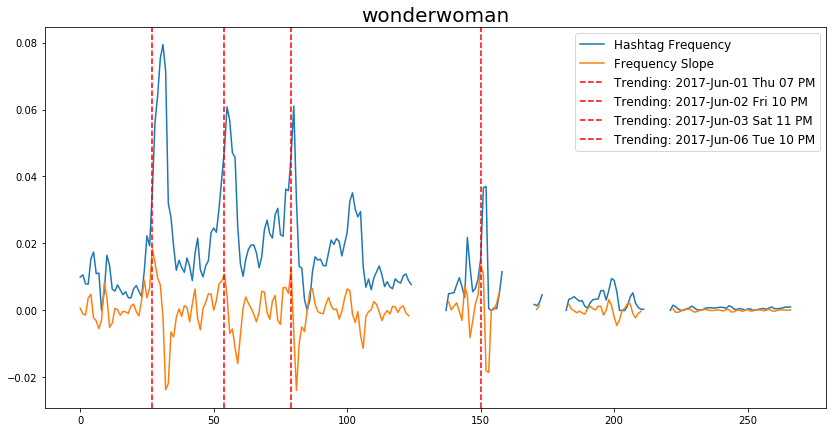

In [94]:
hashtag_trend('wonderwoman')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


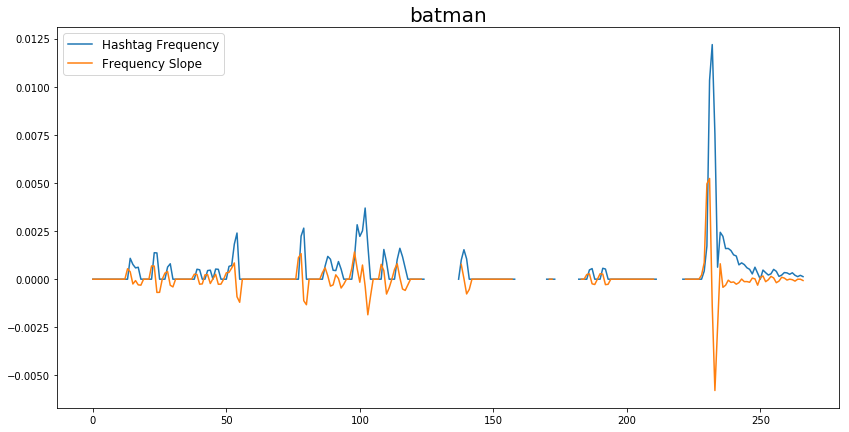

In [87]:
hashtag_trend('batman')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


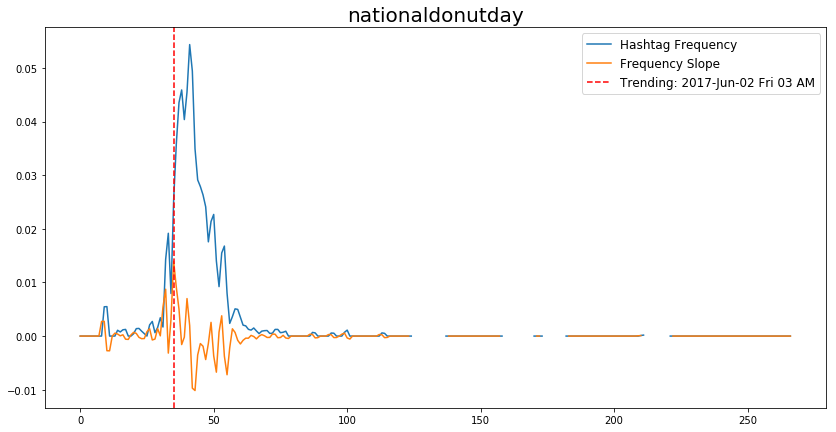

In [88]:
hashtag_trend('nationaldonutday')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


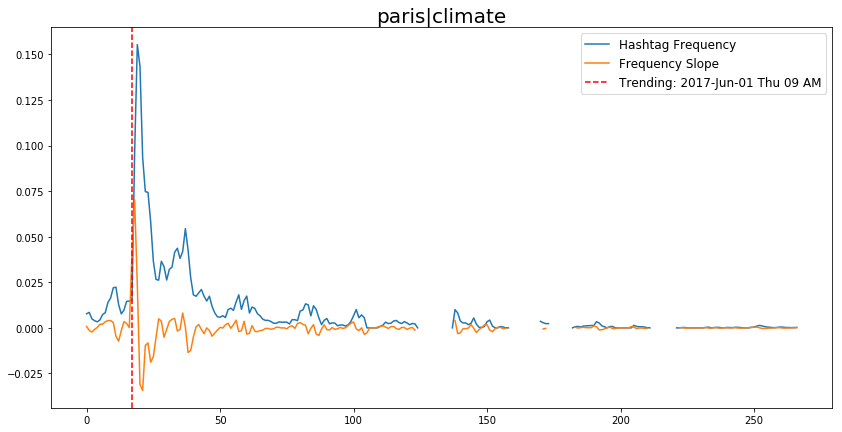

In [89]:
hashtag_trend('paris|climate')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


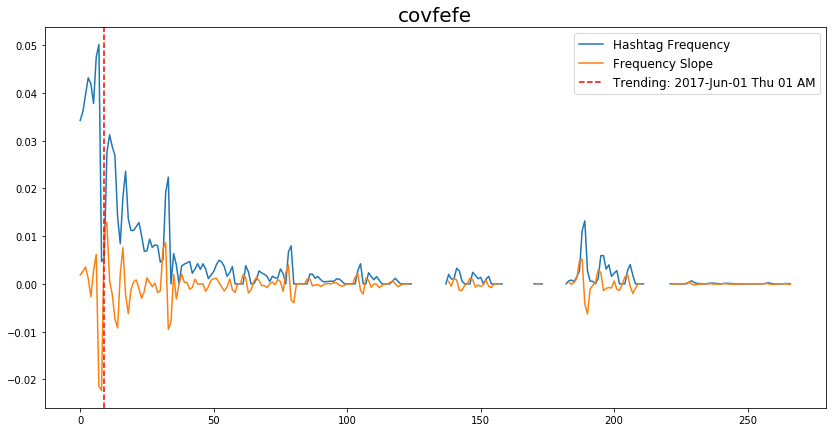

In [90]:
hashtag_trend('covfefe')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


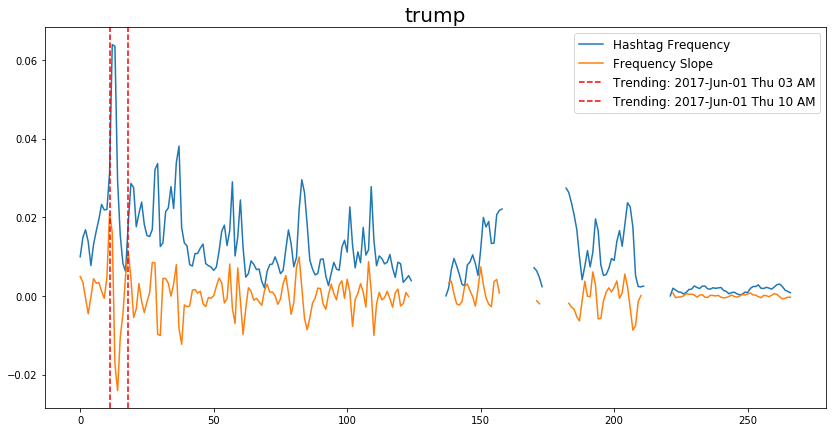

In [93]:
hashtag_trend('trump')